# CNN with the ```150x150``` images

Author: Umberto Michelucci

Teaching Assistant: Kahled Mohamad

In [22]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import string, random
import pandas as pd
import matplotlib.pyplot as plt 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from glob import glob
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score 

This is a shorter way of download the data automatically. The dataset is available in TensorFlow directly,
thanks to the packages ```tensorflow_datasets```. 

In [2]:
prjectName = 'colorectal_histology'

# download the dataset
dataset, info = tfds.load(prjectName, split=f'train', as_supervised=True,with_info=True, shuffle_files=True)
dataset = dataset.shuffle(buffer_size=5000,reshuffle_each_iteration = False)
dataset = dataset.map(lambda img, lbl: (tf.cast(img, tf.float32) / 255.0, lbl))
print(f'dataset type {type(dataset)} with {len(dataset)} images')
print(info.supervised_keys)
print(info.features.items())

dataset type <class 'tensorflow.python.data.ops.dataset_ops.MapDataset'> with 5000 images
('image', 'label')
dict_items([('image', Image(shape=(150, 150, 3), dtype=tf.uint8)), ('label', ClassLabel(shape=(), dtype=tf.int64, num_classes=8)), ('filename', Text(shape=(), dtype=tf.string))])


We prepare the dataset by splitting in batches. This is easy since the previous cell will get us a ```dataset``` datatype.

In [3]:
batch_size = 64
valid_data = dataset.take(1000)

valid_data = valid_data.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_data  = dataset.skip(1000).take(1000)
test_data  = test_data.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_data = dataset.skip(2000).take(3000)
train_data = train_data.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)


## Network Definition

In [4]:

model = tf.keras.Sequential([
        tf.keras.layers.InputLayer((150, 150, 3)),
        tf.keras.layers.Conv2D(64, 3, activation=tf.keras.activations.relu),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(64, 3, activation=tf.keras.activations.relu),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(128, 3, activation=tf.keras.activations.relu),
        tf.keras.layers.AveragePooling2D(),
        tf.keras.layers.Conv2D(128, 3, activation=tf.keras.activations.relu),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(128, 3, activation=tf.keras.activations.relu),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(256, activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(8, activation=tf.keras.activations.softmax)
    ], name='cnn_model')


model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.sparse_categorical_crossentropy,
                  metrics=['accuracy'])
print(model.summary())


Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 average_pooling2d (AverageP  (None, 17, 17, 128)      0 

Next we will define some callbacks for the training to save the model when we get a good result.

In [5]:
# create training callbacks
fullDir = 'assets'
model_name = 'CNN'+''.join(random.sample(string.ascii_lowercase, 12))
earlystop = tf.keras.callbacks.EarlyStopping('val_loss', patience=20, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=f'{fullDir}/ckpts/{prjectName}-{model_name}-' + '{epoch:02d}-{val_accuracy:0.4f}')

In [7]:
# train the model
history = model.fit(train_data, validation_data=valid_data, epochs=20,
                    callbacks=[earlystop, checkpoint])


Epoch 1/20
47/47 [==============================] - ETA: 0s - loss: 1.5720 - accuracy: 0.2983INFO:tensorflow:Assets written to: assets/ckpts/colorectal_histology-CNNpmzvndrgeltf-01-0.4070/assets


INFO:tensorflow:Assets written to: assets/ckpts/colorectal_histology-CNNpmzvndrgeltf-01-0.4070/assets


47/47 [==============================] - 45s 946ms/step - loss: 1.5720 - accuracy: 0.2983 - val_loss: 1.3585 - val_accuracy: 0.4070
Epoch 2/20
47/47 [==============================] - ETA: 0s - loss: 1.1564 - accuracy: 0.4953INFO:tensorflow:Assets written to: assets/ckpts/colorectal_histology-CNNpmzvndrgeltf-02-0.5310/assets


INFO:tensorflow:Assets written to: assets/ckpts/colorectal_histology-CNNpmzvndrgeltf-02-0.5310/assets


47/47 [==============================] - 49s 1s/step - loss: 1.1564 - accuracy: 0.4953 - val_loss: 1.0371 - val_accuracy: 0.5310
Epoch 3/20
47/47 [==============================] - ETA: 0s - loss: 1.0532 - accuracy: 0.5400INFO:tensorflow:Assets written to: assets/ckpts/colorectal_histology-CNNpmzvndrgeltf-03-0.5550/assets


INFO:tensorflow:Assets written to: assets/ckpts/colorectal_histology-CNNpmzvndrgeltf-03-0.5550/assets


47/47 [==============================] - 53s 1s/step - loss: 1.0532 - accuracy: 0.5400 - val_loss: 0.9490 - val_accuracy: 0.5550
Epoch 4/20
47/47 [==============================] - ETA: 0s - loss: 0.9986 - accuracy: 0.5550INFO:tensorflow:Assets written to: assets/ckpts/colorectal_histology-CNNpmzvndrgeltf-04-0.6210/assets


INFO:tensorflow:Assets written to: assets/ckpts/colorectal_histology-CNNpmzvndrgeltf-04-0.6210/assets


47/47 [==============================] - 56s 1s/step - loss: 0.9986 - accuracy: 0.5550 - val_loss: 0.8872 - val_accuracy: 0.6210
Epoch 5/20
47/47 [==============================] - ETA: 0s - loss: 0.9680 - accuracy: 0.5853INFO:tensorflow:Assets written to: assets/ckpts/colorectal_histology-CNNpmzvndrgeltf-05-0.6380/assets


INFO:tensorflow:Assets written to: assets/ckpts/colorectal_histology-CNNpmzvndrgeltf-05-0.6380/assets


47/47 [==============================] - 51s 1s/step - loss: 0.9680 - accuracy: 0.5853 - val_loss: 0.8504 - val_accuracy: 0.6380
Epoch 6/20
47/47 [==============================] - ETA: 0s - loss: 0.9167 - accuracy: 0.6047INFO:tensorflow:Assets written to: assets/ckpts/colorectal_histology-CNNpmzvndrgeltf-06-0.6310/assets


INFO:tensorflow:Assets written to: assets/ckpts/colorectal_histology-CNNpmzvndrgeltf-06-0.6310/assets


47/47 [==============================] - 62s 1s/step - loss: 0.9167 - accuracy: 0.6047 - val_loss: 0.8809 - val_accuracy: 0.6310
Epoch 7/20
47/47 [==============================] - ETA: 0s - loss: 0.8702 - accuracy: 0.6353INFO:tensorflow:Assets written to: assets/ckpts/colorectal_histology-CNNpmzvndrgeltf-07-0.6250/assets


INFO:tensorflow:Assets written to: assets/ckpts/colorectal_histology-CNNpmzvndrgeltf-07-0.6250/assets


47/47 [==============================] - 56s 1s/step - loss: 0.8702 - accuracy: 0.6353 - val_loss: 0.8750 - val_accuracy: 0.6250
Epoch 8/20
47/47 [==============================] - ETA: 0s - loss: 0.8732 - accuracy: 0.6437INFO:tensorflow:Assets written to: assets/ckpts/colorectal_histology-CNNpmzvndrgeltf-08-0.5960/assets


INFO:tensorflow:Assets written to: assets/ckpts/colorectal_histology-CNNpmzvndrgeltf-08-0.5960/assets


47/47 [==============================] - 54s 1s/step - loss: 0.8732 - accuracy: 0.6437 - val_loss: 0.9703 - val_accuracy: 0.5960
Epoch 9/20
47/47 [==============================] - ETA: 0s - loss: 0.8495 - accuracy: 0.6427INFO:tensorflow:Assets written to: assets/ckpts/colorectal_histology-CNNpmzvndrgeltf-09-0.6980/assets


INFO:tensorflow:Assets written to: assets/ckpts/colorectal_histology-CNNpmzvndrgeltf-09-0.6980/assets


47/47 [==============================] - 55s 1s/step - loss: 0.8495 - accuracy: 0.6427 - val_loss: 0.7441 - val_accuracy: 0.6980
Epoch 10/20
47/47 [==============================] - ETA: 0s - loss: 0.7674 - accuracy: 0.6913INFO:tensorflow:Assets written to: assets/ckpts/colorectal_histology-CNNpmzvndrgeltf-10-0.6890/assets


INFO:tensorflow:Assets written to: assets/ckpts/colorectal_histology-CNNpmzvndrgeltf-10-0.6890/assets


47/47 [==============================] - 55s 1s/step - loss: 0.7674 - accuracy: 0.6913 - val_loss: 0.7748 - val_accuracy: 0.6890
Epoch 11/20
47/47 [==============================] - ETA: 0s - loss: 0.7452 - accuracy: 0.7067INFO:tensorflow:Assets written to: assets/ckpts/colorectal_histology-CNNpmzvndrgeltf-11-0.6590/assets


INFO:tensorflow:Assets written to: assets/ckpts/colorectal_histology-CNNpmzvndrgeltf-11-0.6590/assets


47/47 [==============================] - 55s 1s/step - loss: 0.7452 - accuracy: 0.7067 - val_loss: 0.8450 - val_accuracy: 0.6590
Epoch 12/20
47/47 [==============================] - ETA: 0s - loss: 0.6911 - accuracy: 0.7360INFO:tensorflow:Assets written to: assets/ckpts/colorectal_histology-CNNpmzvndrgeltf-12-0.6910/assets


INFO:tensorflow:Assets written to: assets/ckpts/colorectal_histology-CNNpmzvndrgeltf-12-0.6910/assets


47/47 [==============================] - 49s 1s/step - loss: 0.6911 - accuracy: 0.7360 - val_loss: 0.8099 - val_accuracy: 0.6910
Epoch 13/20
47/47 [==============================] - ETA: 0s - loss: 0.6489 - accuracy: 0.7457INFO:tensorflow:Assets written to: assets/ckpts/colorectal_histology-CNNpmzvndrgeltf-13-0.7260/assets


INFO:tensorflow:Assets written to: assets/ckpts/colorectal_histology-CNNpmzvndrgeltf-13-0.7260/assets


47/47 [==============================] - 53s 1s/step - loss: 0.6489 - accuracy: 0.7457 - val_loss: 0.6738 - val_accuracy: 0.7260
Epoch 14/20
47/47 [==============================] - ETA: 0s - loss: 0.6034 - accuracy: 0.7653INFO:tensorflow:Assets written to: assets/ckpts/colorectal_histology-CNNpmzvndrgeltf-14-0.7350/assets


INFO:tensorflow:Assets written to: assets/ckpts/colorectal_histology-CNNpmzvndrgeltf-14-0.7350/assets


47/47 [==============================] - 49s 1s/step - loss: 0.6034 - accuracy: 0.7653 - val_loss: 0.6518 - val_accuracy: 0.7350
Epoch 15/20
47/47 [==============================] - ETA: 0s - loss: 0.5772 - accuracy: 0.7750INFO:tensorflow:Assets written to: assets/ckpts/colorectal_histology-CNNpmzvndrgeltf-15-0.7490/assets


INFO:tensorflow:Assets written to: assets/ckpts/colorectal_histology-CNNpmzvndrgeltf-15-0.7490/assets


47/47 [==============================] - 48s 1s/step - loss: 0.5772 - accuracy: 0.7750 - val_loss: 0.6334 - val_accuracy: 0.7490
Epoch 16/20
47/47 [==============================] - ETA: 0s - loss: 0.5420 - accuracy: 0.7970INFO:tensorflow:Assets written to: assets/ckpts/colorectal_histology-CNNpmzvndrgeltf-16-0.7570/assets


INFO:tensorflow:Assets written to: assets/ckpts/colorectal_histology-CNNpmzvndrgeltf-16-0.7570/assets


47/47 [==============================] - 50s 1s/step - loss: 0.5420 - accuracy: 0.7970 - val_loss: 0.6181 - val_accuracy: 0.7570
Epoch 17/20
47/47 [==============================] - ETA: 0s - loss: 0.5419 - accuracy: 0.7910INFO:tensorflow:Assets written to: assets/ckpts/colorectal_histology-CNNpmzvndrgeltf-17-0.7550/assets


INFO:tensorflow:Assets written to: assets/ckpts/colorectal_histology-CNNpmzvndrgeltf-17-0.7550/assets


47/47 [==============================] - 51s 1s/step - loss: 0.5419 - accuracy: 0.7910 - val_loss: 0.6191 - val_accuracy: 0.7550
Epoch 18/20
47/47 [==============================] - ETA: 0s - loss: 0.5207 - accuracy: 0.8007INFO:tensorflow:Assets written to: assets/ckpts/colorectal_histology-CNNpmzvndrgeltf-18-0.7810/assets


INFO:tensorflow:Assets written to: assets/ckpts/colorectal_histology-CNNpmzvndrgeltf-18-0.7810/assets


47/47 [==============================] - 50s 1s/step - loss: 0.5207 - accuracy: 0.8007 - val_loss: 0.5610 - val_accuracy: 0.7810
Epoch 19/20
47/47 [==============================] - ETA: 0s - loss: 0.5017 - accuracy: 0.8077INFO:tensorflow:Assets written to: assets/ckpts/colorectal_histology-CNNpmzvndrgeltf-19-0.8050/assets


INFO:tensorflow:Assets written to: assets/ckpts/colorectal_histology-CNNpmzvndrgeltf-19-0.8050/assets


47/47 [==============================] - 53s 1s/step - loss: 0.5017 - accuracy: 0.8077 - val_loss: 0.5079 - val_accuracy: 0.8050
Epoch 20/20
47/47 [==============================] - ETA: 0s - loss: 0.4692 - accuracy: 0.8163INFO:tensorflow:Assets written to: assets/ckpts/colorectal_histology-CNNpmzvndrgeltf-20-0.7910/assets


INFO:tensorflow:Assets written to: assets/ckpts/colorectal_histology-CNNpmzvndrgeltf-20-0.7910/assets


47/47 [==============================] - 55s 1s/step - loss: 0.4692 - accuracy: 0.8163 - val_loss: 0.5459 - val_accuracy: 0.7910


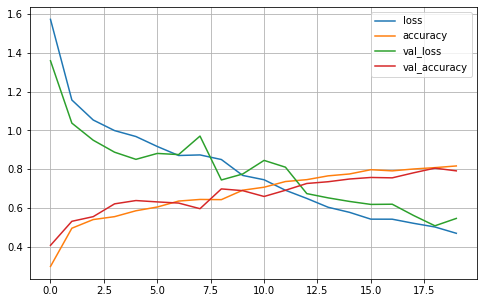

16/16 [==============================] - 6s 292ms/step - loss: 0.5282 - accuracy: 0.7960
[0.5282454490661621, 0.7960000038146973]


In [8]:

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 1)
plt.show()
print(model.evaluate(test_data))


In [9]:

test_loss, test_acc = model.evaluate(test_data)
print(f'Test accuracy:{test_acc * 100:.2f}%')

16/16 [==============================] - 5s 282ms/step - loss: 0.5282 - accuracy: 0.7960
Test accuracy:79.60%


## Confusion Matrix of the Results

To get the confusion matrix we need an array with the predictions and one with the true labels. Since we are using a tensorflow dataset, we need to extract those information. The next cell does exactly that.

In [75]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_data:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))


Since the previous cell will return a list of tensors and numpy arrays we need to flatten them. This is done in the next cell.

In [99]:
# We flatten the list
labels = [x.numpy() for x in y_true]
labels = [list(x) for x in labels]
labels = [item for sublist in labels for item in sublist]
#print(labels)

#preds = [x.numpy() for x in y_pred]
y_preds = [list(x) for x in y_pred]
y_preds = [item for sublist in y_preds for item in sublist]

print(len(labels), len(y_preds))

1000 1000


In [110]:
confusion_matrix(labels, y_preds)

array([[117,   2,   2,   5,   0,   9,   0,   0],
       [  0,  86,  13,   0,  22,   7,   1,   0],
       [ 10,  12,  70,   5,   1,  13,   0,   0],
       [  5,   0,   3, 100,   0,   8,   0,   0],
       [  0,  15,   3,   0, 101,   6,   6,   0],
       [ 20,   1,   0,   1,   8,  96,   0,   0],
       [  0,   0,   0,   0,   1,   0, 107,  24],
       [  0,   0,   0,   0,   0,   0,   1, 119]])

Text(0.5, 1.0, 'Accuracy: 79.60')

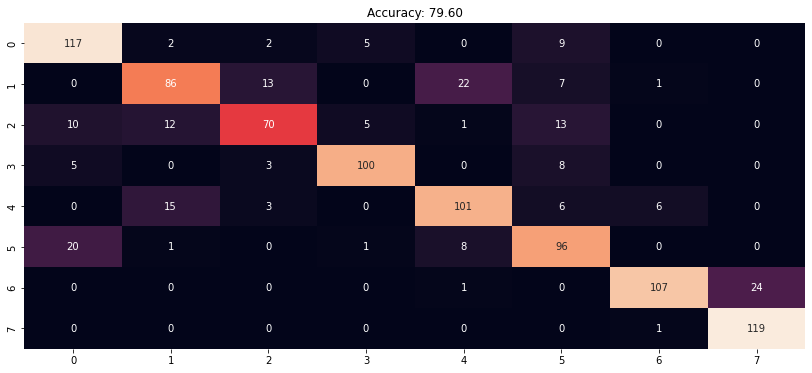

In [105]:
fig = plt.figure(figsize = (14,6))
sns.heatmap(confusion_matrix(labels, y_preds), 
                    annot=True, cbar=False, fmt='d')
plt.title(f'Accuracy: {accuracy_score(labels,y_preds)*100:2.2f}')

# Heatmap on Larger Images

## Loading large images

First we need to load the larger images. Keep in mind that those are quite big, so if your laptop has not so much memory, your computer may be very slow.

In [10]:
base_tile_dir = os.path.join('', '../data/large_images')

big_image_df = pd.DataFrame({
    'path': glob(os.path.join(base_tile_dir,  '*.tif'))
})

print(big_image_df.iloc[0])
big_image_df['image'] = big_image_df['path'].map(plt.imread)

path    ../data/large_images/CRC-Prim-HE-06_APPLICATIO...
Name: 0, dtype: object


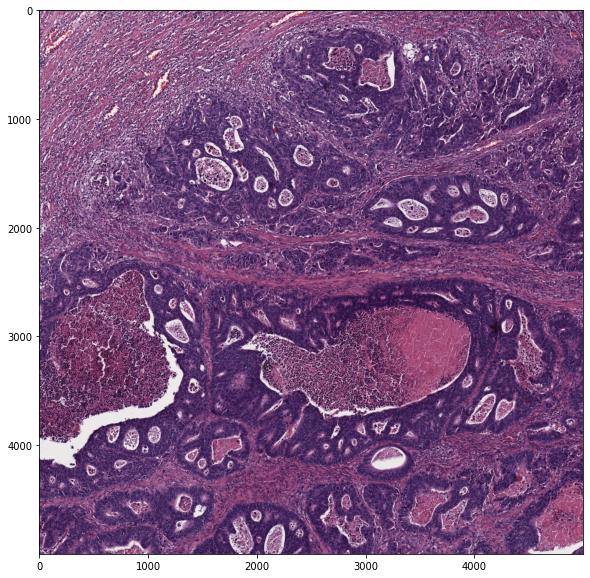

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(big_image_df['image'].iloc[2])
plt.show()

In [12]:
# Choose the large image that we want to check
image_idx = 2
large_img =  big_image_df['image'].iloc[image_idx] / 255.0
#print(large_img)

# Each model has been trained on images 150x150. The models
# trained with the CSV files, has been trained with those images
# that have been reduced in size and that have been made (if the name
# ends in L) black and white. This is why we need the following constants
# to reshape and conver the portions of the large image.
size_x = 150
size_y = 150
#size_red_x = 8
#size_red_y = 8
# Now we iterate over small portions of the large image and always apply our classifier.
num_x = int(5000/size_x)
num_y = int(5000/size_y)
#print(num_x, num_y)

print("Number of predictions: ", num_x*num_y)

preds_list = []
for ix in range (num_x):
    for iy in range (num_y):
        portion = large_img[ix*size_x: (ix+1)*size_x, iy*size_y: (iy+1)*size_y,:]
        #print(portion.shape)

        # Now we will reduce the image size to size_red_x x size_red_y
        #img = Image.fromarray(np.uint8(portion)) # Convert the array to PIL image format
        #imgL = img.convert("L") # Convert to gray levels, since we are going to use a model trained with gray images
        #imgLR = imgL.resize ((8,8)) # reshape to 8x8
        imgLR_array = np.expand_dims(portion, axis = 0)
        #print(imgLR_array.shape)
        
        pred_ = model.predict(imgLR_array) # We get the highest probabilty value predicted
        preds_list.append(pred_[0,0]) # We put the probability value in a list that we will use later

# Now we create the mask that we will overimpose on the image
mask_image = np.zeros((large_img.shape[0], large_img.shape[1])) # The mask image will have only one color channel
for ix in range (num_x):
    for iy in range (num_y):
        mask_image[ix*size_x: (ix+1)*size_x, iy*size_y: (iy+1)*size_y] = preds_list[iy+ix*num_x]

Number of predictions:  1089


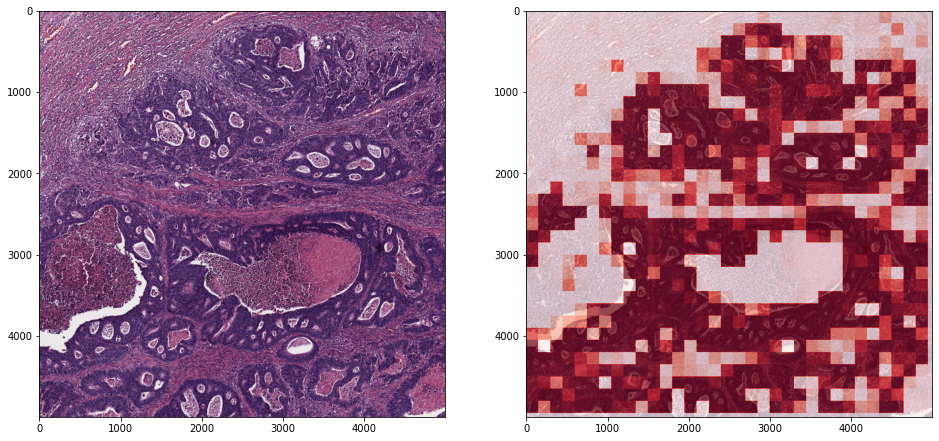

In [13]:
fig = plt.figure(figsize = (16,8))
plt.subplot(121)
plt.imshow(large_img)
plt.subplot(122)
plt.imshow(large_img)
plt.imshow(mask_image, alpha = 0.7, cmap = "Reds")